# Segmentation Task - Baseline

In [1]:
import os
import pathlib
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import constants
from utils.io import save_model

%matplotlib inline

## Data Loading

In [2]:
metadata_df = pd.read_csv(constants.METADATA_FILE)

In [3]:
segmentation_df = metadata_df.loc[(metadata_df['task'] == 'segmentation') & (metadata_df['linked_image'].notnull())]
segmentation_df = segmentation_df.reset_index(drop=True)
segmentation_df.head()

,relative_path,filename,task,split,index,tumor_code,tumor_label,plane_code,plane_label,sequence,is_mask,linked_image,width,height,file_size_bytes,sha256
0,segmentation_task\test\masks\brisc2025_test_00...,brisc2025_test_00001_gl_ax_t1.png,segmentation,test,1,gl,glioma,ax,axial,T1,True,segmentation_task\test\images\brisc2025_test_0...,512,512,1346,b845c30192064e29c0ce59750a6ab0930b7839006e13c2...
1,segmentation_task\test\masks\brisc2025_test_00...,brisc2025_test_00002_gl_ax_t1.png,segmentation,test,2,gl,glioma,ax,axial,T1,True,segmentation_task\test\images\brisc2025_test_0...,512,512,1635,b6fe3c48fcdb401199eb610681bf9c944c69f64eeb314e...
2,segmentation_task\test\masks\brisc2025_test_00...,brisc2025_test_00003_gl_ax_t1.png,segmentation,test,3,gl,glioma,ax,axial,T1,True,segmentation_task\test\images\brisc2025_test_0...,512,512,3605,07f1358d2a7441e2e7b8775732cc3e0c7b17feedfcb0a1...
3,segmentation_task\test\masks\brisc2025_test_00...,brisc2025_test_00004_gl_ax_t1.png,segmentation,test,4,gl,glioma,ax,axial,T1,True,segmentation_task\test\images\brisc2025_test_0...,512,512,2869,ceb0589b4232e75533d90d731b8c1847612fc8db14cfea...
4,segmentation_task\test\masks\brisc2025_test_00...,brisc2025_test_00005_gl_ax_t1.png,segmentation,test,5,gl,glioma,ax,axial,T1,True,segmentation_task\test\images\brisc2025_test_0...,512,512,1513,31583073f4767b475abb2918e24a3182396c8df7030f5b...


In [4]:
segmentation_df = segmentation_df.rename(columns={'relative_path': 'mask_path', 'linked_image': 'image_path'})

In [5]:
segmentation_df.loc[:, 'mask_path'] = segmentation_df['mask_path'].str.replace('\\', '/')
segmentation_df.loc[:, 'image_path'] = segmentation_df['image_path'].str.replace('\\', '/')

In [6]:
train_df = segmentation_df.loc[segmentation_df['split'] == 'train', ['image_path', 'mask_path']]
test_df = segmentation_df.loc[segmentation_df['split'] == 'test', ['image_path', 'mask_path']]

In [7]:
train_df.shape, test_df.shape

((3933, 2), (860, 2))

### Data Preprocessing

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2

from PIL import Image 

In [9]:
class TumorSegDataset(Dataset):
    def __init__(self, image_df: pd.DataFrame, transforms=None):
        self.df = image_df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path, mask_path = self.df.iloc[idx]
        image = Image.open(os.path.join(constants.BRISC_DATA_PATH / image_path))
        mask = Image.open(os.path.join(constants.BRISC_DATA_PATH / mask_path))

        if self.transforms is not None:
            image, mask = self.transforms(image, mask)
        mask = mask / 255.0
        
        return image, mask

In [10]:
train_pipeline = v2.Compose([
    v2.Resize((256, 256)),
    v2.Grayscale(),
    v2.RandomVerticalFlip(p=0.3),
    v2.RandomHorizontalFlip(p=0.3),
    v2.ToImage(),
    v2.ToDtype(torch.float32),
])

test_pipeline = v2.Compose([
    v2.Resize((256, 256)),
    v2.Grayscale(),
    v2.ToImage(),
    v2.ToDtype(torch.float32)
])

In [11]:
dataset = TumorSegDataset(train_df, transforms=train_pipeline)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])
test_dataset = TumorSegDataset(test_df, transforms=test_pipeline)

In [12]:
len(train_dataset), len(val_dataset), len(test_dataset)

(3147, 786, 860)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

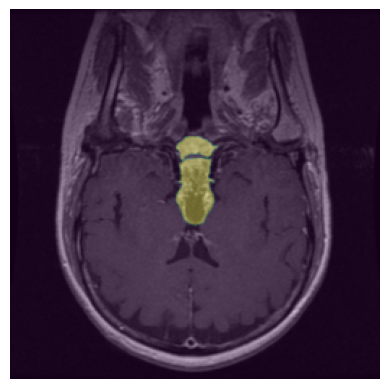

In [14]:
img, mask = dataset[train_dataset.indices[1]]

plt.imshow(img.squeeze(), cmap='gray')
plt.imshow(mask.squeeze(), alpha=0.3)
plt.axis('off')
plt.show()

## Model Training

In [15]:
import torch
from torch import nn, optim
import segmentation_models_pytorch as smp

from torchmetrics.segmentation import DiceScore

In [16]:
def dice_score(preds, targets, eps=1e-6):
    assert preds.size() == targets.size()
    
    preds = preds.view(-1)
    targets = targets.view(-1)

    intersection = (preds * targets).sum()
    preds_sum = preds.sum()
    targets_sum = targets.sum()

    dice = (2 * intersection + eps) / (targets_sum + preds_sum + eps)
    return dice

In [17]:
def train_loop(model, dataloader, loss_fn, optimizer, *, device='cpu'):
    train_loss = 0
    num_batches = len(dataloader)
    dice_scores = []

    model.train()

    for batch, (image, mask) in enumerate(dataloader):
        optimizer.zero_grad()
        
        image = image.to(device)
        mask = mask.to(device)

        pred = model(image) # Assuming our loss expects logits
        loss = loss_fn(pred, mask)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() 

        preds = torch.sigmoid(pred)
        pred_mask = (preds >= 0.5).float()
        dice_scores.append(dice_score(pred_mask, mask).item())

    epoch_loss = train_loss / num_batches
    epoch_metric = np.mean(dice_scores)

    print(f"Train Loss: {epoch_loss:.4f} - Dice Score: {epoch_metric:.4f}")

    return epoch_loss, epoch_metric

In [18]:
def test_loop(model, dataloader, loss_fn, *, device='cpu', mode='test'):
    num_batches = len(dataloader)
    dice_scores = []
    total_loss = 0.0

    model.eval()
    
    for image, mask in dataloader:
        image = image.to(device)
        mask = mask.to(device)
    
        with torch.no_grad():
            logits = model(image)
            total_loss += loss_fn(logits, mask).item()

            # Make the prediction
            preds = torch.sigmoid(logits)
            pred_mask = (preds >= 0.5).float()
            dice_scores.append(dice_score(pred_mask, mask).item())

    epoch_loss = total_loss / num_batches
    epoch_metric = np.mean(dice_scores)

    if mode == 'val':
        print(f"Val loss: {epoch_loss:.4f} - Dice Score: {epoch_metric:4f}")
        return epoch_loss, epoch_metric
    return epoch_metric

In [19]:
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.mps.is_available() else
    'cpu'
)

print(f"Accelerator: {device}")

Accelerator: mps


### MobileNetV2 + UNet

In [20]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', in_channels=1, classes=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

In [21]:
for name, param in model.encoder.named_parameters():
    if not name.startswith('features.18'):
        param.requires_grad = False

In [22]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

4817233

In [23]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, tds = train_loop(model, train_loader, loss_fn, optimizer, device=device)
    val_loss, vds = test_loop(model, val_loader, loss_fn, device=device, mode='val')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_dice_score'].append(tds)
    history['val_dice_score'].append(vds)

Epoch 1
---------------
Train Loss: 0.4773 - Dice Score: 0.1771
Val loss: 0.3103 - Dice Score: 0.281256
Epoch 2
---------------
Train Loss: 0.2466 - Dice Score: 0.3711
Val loss: 0.2140 - Dice Score: 0.509380
Epoch 3
---------------
Train Loss: 0.1739 - Dice Score: 0.6213
Val loss: 0.1537 - Dice Score: 0.649068
Epoch 4
---------------
Train Loss: 0.1322 - Dice Score: 0.6858
Val loss: 0.1207 - Dice Score: 0.658491
Epoch 5
---------------
Train Loss: 0.1061 - Dice Score: 0.7245
Val loss: 0.0966 - Dice Score: 0.705256
Epoch 6
---------------
Train Loss: 0.0856 - Dice Score: 0.7488
Val loss: 0.0805 - Dice Score: 0.720287
Epoch 7
---------------
Train Loss: 0.0716 - Dice Score: 0.7700
Val loss: 0.0683 - Dice Score: 0.741443
Epoch 8
---------------
Train Loss: 0.0606 - Dice Score: 0.7863
Val loss: 0.0594 - Dice Score: 0.734462
Epoch 9
---------------
Train Loss: 0.0520 - Dice Score: 0.7946
Val loss: 0.0521 - Dice Score: 0.744611
Epoch 10
---------------
Train Loss: 0.0445 - Dice Score: 0.8168

### Model Evaluation

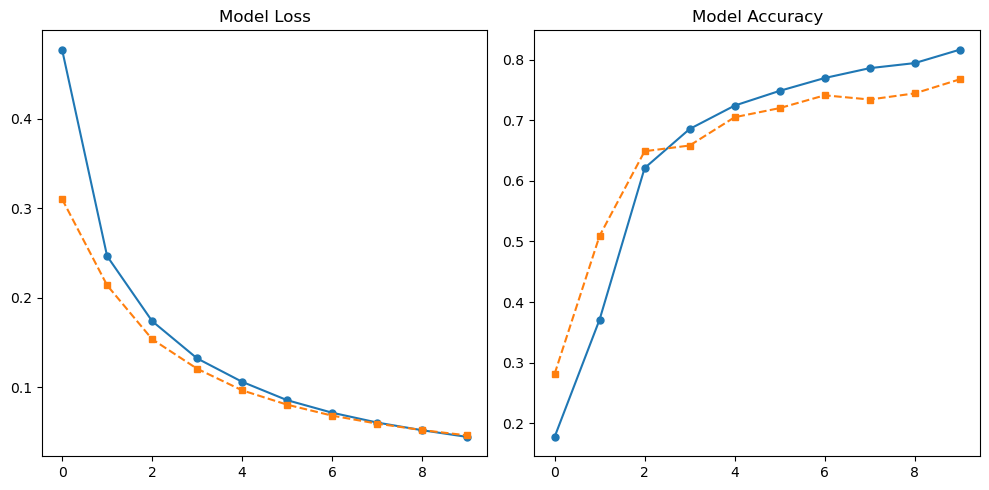

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history['train_loss'], 'o-', markersize=5)
ax1.plot(history['val_loss'], 's--', markersize=5)
ax1.set_title('Model Loss')

ax2.plot(history['train_dice_score'], 'o-', markersize=5)
ax2.plot(history['val_dice_score'], 's--', markersize=5)
ax2.set_title('Model Accuracy')

plt.tight_layout()
plt.show()

In [25]:
test_dice_score = test_loop(model, test_loader, loss_fn, device=device)
print(f'Test Dice Score: {test_dice_score:4f}')

Test Dice Score: 0.785782


In [26]:
image, true_mask = test_dataset[90]
pred_mask = model(image.unsqueeze(0).to(device))

In [27]:
pred_mask = (torch.sigmoid(pred_mask) >= 0.5).float().cpu()

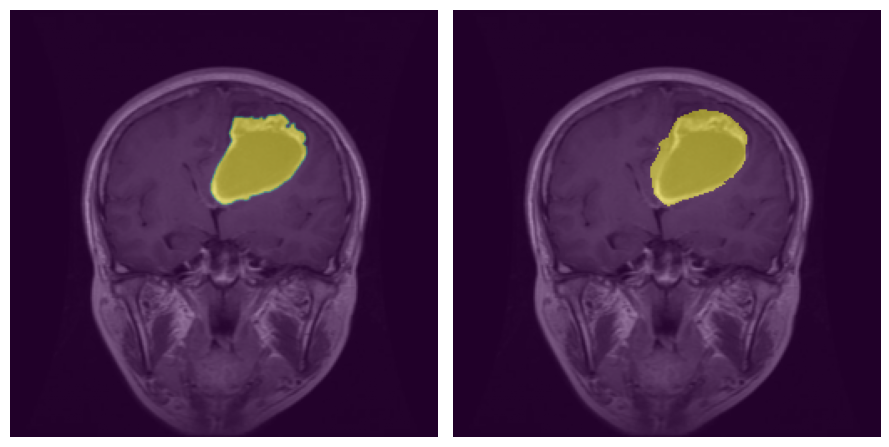

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))

ax1.imshow(image.squeeze(), cmap='gray')
ax1.imshow(true_mask.squeeze(), alpha=0.5)
ax1.set_axis_off()

ax2.imshow(image.squeeze(), cmap='gray')
ax2.imshow(pred_mask.squeeze(), alpha=0.5)
ax2.set_axis_off()

plt.tight_layout()
plt.savefig('figures/segmentation_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
save_model(model, 'mobile-unet.pth')

### EfficientNetB0 + UNet

In [41]:
model = smp.Unet('efficientnet-b0', encoder_weights='imagenet', in_channels=1, classes=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

In [42]:
for name, param in model.encoder.named_parameters():
    if not name.startswith('_blocks.15'):
        param.requires_grad = False

In [43]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

2961153

In [44]:
history = defaultdict(list)

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n---------------')
    train_loss, tds = train_loop(model, train_loader, loss_fn, optimizer, device=device)
    val_loss, vds = test_loop(model, val_loader, loss_fn, device=device, mode='val')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_dice_score'].append(tds)
    history['val_dice_score'].append(vds)

Epoch 1
---------------
Train Loss: 0.3144 - Dice Score: 0.2904
Val loss: 0.2112 - Dice Score: 0.649447
Epoch 2
---------------
Train Loss: 0.1558 - Dice Score: 0.7151
Val loss: 0.1256 - Dice Score: 0.724861
Epoch 3
---------------
Train Loss: 0.1044 - Dice Score: 0.7627
Val loss: 0.0954 - Dice Score: 0.756650
Epoch 4
---------------
Train Loss: 0.0776 - Dice Score: 0.7891
Val loss: 0.0699 - Dice Score: 0.795351
Epoch 5
---------------
Train Loss: 0.0604 - Dice Score: 0.8098
Val loss: 0.0573 - Dice Score: 0.803907
Epoch 6
---------------
Train Loss: 0.0488 - Dice Score: 0.8242
Val loss: 0.0463 - Dice Score: 0.812795
Epoch 7
---------------
Train Loss: 0.0408 - Dice Score: 0.8338
Val loss: 0.0396 - Dice Score: 0.811114
Epoch 8
---------------
Train Loss: 0.0345 - Dice Score: 0.8475
Val loss: 0.0344 - Dice Score: 0.817217
Epoch 9
---------------
Train Loss: 0.0298 - Dice Score: 0.8584
Val loss: 0.0311 - Dice Score: 0.834550
Epoch 10
---------------
Train Loss: 0.0261 - Dice Score: 0.8663

### Model Evaluation

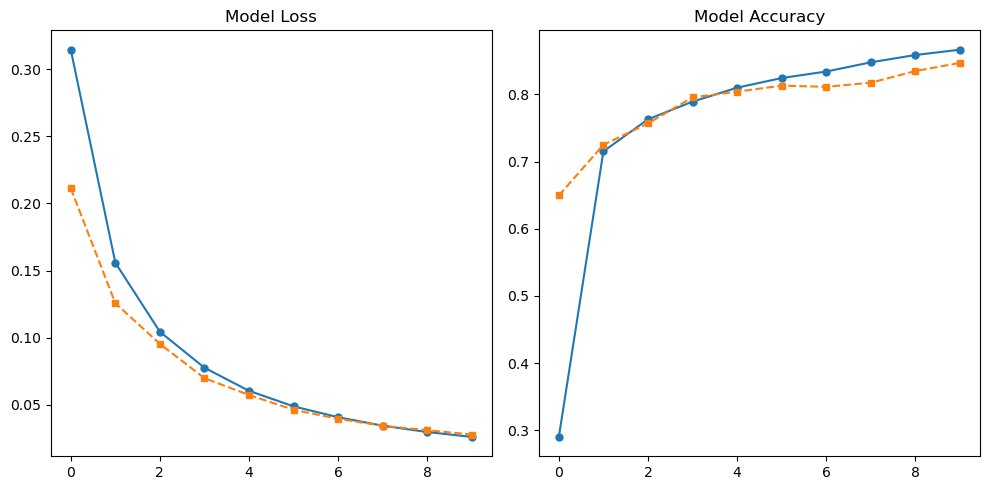

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history['train_loss'], 'o-', markersize=5)
ax1.plot(history['val_loss'], 's--', markersize=5)
ax1.set_title('Model Loss')

ax2.plot(history['train_dice_score'], 'o-', markersize=5)
ax2.plot(history['val_dice_score'], 's--', markersize=5)
ax2.set_title('Model Accuracy')

plt.tight_layout()
plt.show()

In [46]:
test_dice_score = test_loop(model, test_loader, loss_fn, device=device)
print(f'Test Dice Score: {test_dice_score:4f}')

Test Dice Score: 0.841381


In [47]:
image, true_mask = test_dataset[90]
pred_mask = model(image.unsqueeze(0).to(device))

In [48]:
pred_mask = (torch.sigmoid(pred_mask) >= 0.5).float().cpu()

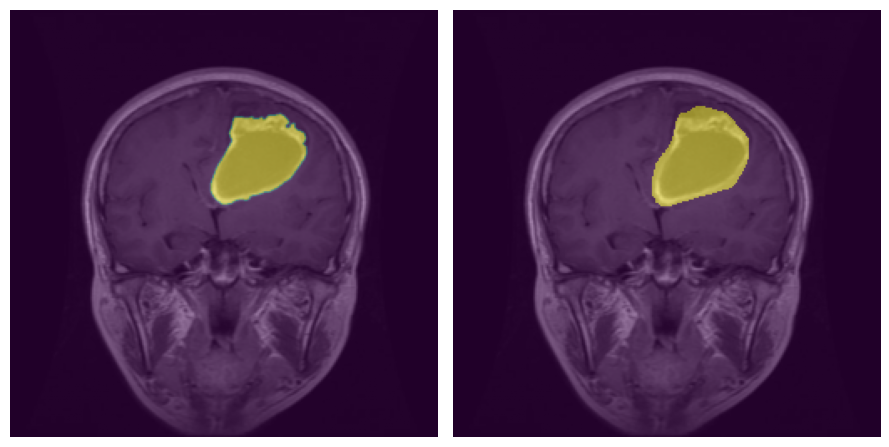

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))

ax1.imshow(image.squeeze(), cmap='gray')
ax1.imshow(true_mask.squeeze(), alpha=0.5)
ax1.set_axis_off()

ax2.imshow(image.squeeze(), cmap='gray')
ax2.imshow(pred_mask.squeeze(), alpha=0.5)
ax2.set_axis_off()

plt.tight_layout()
plt.savefig('figures/segmentation_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
save_model(model, 'efficient-unet.pth')